In [ ]:
#| default_exp sampler.direct

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import qsample.math as math
import qsample.utils as utils
from tqdm.auto import tqdm
from qsample.callbacks import CallbackList

In [ ]:
#| export
class DirectSampler:
    """Direct Monte Carlo Sampler
    
    Attributes
    ----------
    protocol : Protocol
        Protocol to sample from
    simulator : StabilizerSimulator or StatevectorSimulator
        Simulator used during sampling
    err_model : ErrorModel
        Error model used during sampling
    err_params : dict
        Physical error rates per faulty partition group at which plots generated.  
    partitions : dict
        Grouping of faulty circuit elements fore each circuit in protocol
    counts : np.array
        List to accumulate counts for "marked" events
    shots : np.array
        List to accumulate shots per physical error rate
    """
    
    def __init__(self, protocol, simulator, err_model, err_params=None):
        """
        Parameters
        ----------
        protocol : Protocol
            The protocol to sample from
        simulator : ChpSimulator or StatevectorSimulator
            The simulator used in sampling process
        err_model : ErrorModel
            Error model used in sampling process
        err_params : dict
            Physical error rates per faulty partition group at which plots generated.
        """
        self.protocol = protocol
        self.simulator = simulator
        self.err_model = err_model()
        self.err_params = self.__err_params_to_matrix(err_params)
        self.partitions = {cid: self.err_model.group(circuit) for cid, circuit in self.protocol.circuits.items()}
        self.counts = np.array([0] * self.err_params.shape[0])
        self.shots = np.array([0] * self.err_params.shape[0])
        
    def __err_params_to_matrix(self, err_params):
        sorted_params = [err_params[k] for k in self.err_model.groups]
        return np.array(np.broadcast_arrays(*sorted_params)).T
    
    def save(self, path):
        """Save sampler to path
        
        Parameters
        ----------
        path : str
            File path to save to
        """
        utils.save(path)
            
    def stats(self, idx=None):
        """Calculate sampling statistics
        
        Returns
        -------
        tuple
            (Logical failure rate, Wilson variance on logical failure rate)
        """
        p_L = np.array([0 if s==0 else c/s for (c,s) in zip(self.counts, self.shots)])
        v_L = math.Wilson_var(p_L, self.shots)
        if idx != None: p_L, v_L = p_L[idx], v_L[idx]
        
        return p_L, np.sqrt(v_L)
            
    def run(self, n_shots, callbacks=[]):
        """Execute n_shots of subset sampling
        
        Parameters
        ----------
        n_shots : int
            Number of shots sampled in total
        callbacks : list of Callback
            Callback instances executed during sampling
        """
        self.n_shots = n_shots
        
        if not isinstance(callbacks, CallbackList):
            callbacks = CallbackList(sampler=self, callbacks=callbacks)
                    
        callbacks.on_sampler_begin()
        
        for i, p in enumerate(self.err_params):
            
            self.stop_sampling = False # Flag can be controlled in callbacks
            self.i = i
            
            for _ in tqdm(range(n_shots), desc=f"p={tuple(map('{:.2e}'.format, p))}", leave=True):
                
                self.shots[i] += 1
                callbacks.on_protocol_begin()
                pnode = self.protocol.root # get protocol start node
                state = self.simulator(len(self.protocol.qubits)) # init state
                msmt_hist = {} # init measurement history
                
                while True:
                    callbacks.on_circuit_begin()
                    pnode, circuit = self.protocol.successor(pnode, msmt_hist)
                    if circuit:
                        if not circuit._noisy:
                            msmt = state.run(circuit)
                        else:
                            fault_locs = self.err_model.choose_p(self.partitions[circuit.id], p)
                            fault_circuit = self.err_model.run(circuit, fault_locs)
                            msmt = state.run(circuit, fault_circuit)
                        msmt = msmt if msmt==None else int(msmt,2) # convert to int for comparison in checks
                        msmt_hist[pnode] = msmt_hist.get(pnode, []) + [msmt]
                    else:
                        if pnode != None:
                            # "Interesting" event happened
                            self.counts[i] += 1
                        break
                    callbacks.on_circuit_end(locals())
                callbacks.on_protocol_end()
                if self.stop_sampling:
                    break
        
        del self.stop_sampling
        callbacks.on_sampler_end()

In [ ]:
#| slow
from qsample.examples import ghz3
from qsample.noise import E1, E2
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.callbacks import *

p=('1.00e-03',):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('5.62e-03',):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('3.16e-02',):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.78e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e+00',):   0%|          | 0/1000 [00:00<?, ?it/s]

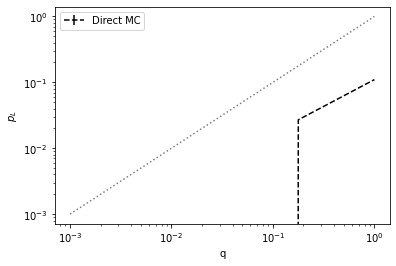

In [ ]:
#| slow

e = E1

sample_range = np.logspace(-3,0,5)

err_probs = {
    "q": sample_range,
}

sam = DirectSampler(ghz3, CHP, err_params=err_probs, err_model=e)

sam.run(1000, callbacks=[PlotStats()])

p=('1.00e-02', '1.00e-03'):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e-02', '5.62e-03'):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e-02', '3.16e-02'):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e-02', '1.78e-01'):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e-02', '1.00e+00'):   0%|          | 0/1000 [00:00<?, ?it/s]

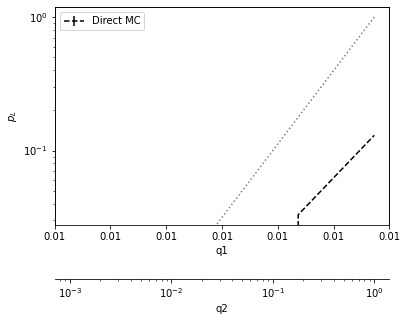

In [ ]:
#| slow

e = E2

sample_range = np.logspace(-3,0,5)

err_params = {
    "q2": sample_range,
    "q1": 0.01
}

sam = DirectSampler(ghz3, CHP, err_params=err_params, err_model=e)

sam.run(1000, callbacks=[PlotStats()])